# Movie Data Analysis Project 

##### Students: William Bennett, Alex Karadjov

##### Instructor: David Elliot

##### Active Project Dates: May 8th - 12th

<img src='images/movie-producer-1000x600.jpg' width="600" height="400">


## Business Understanding
#### Business Question
ACME corperation (made up company) has now seen all the other big companies creating original video content. Your companies board have _decided to create a new movie studio_, but they don’t know anything about _creating movies._ 
<br>

<img src='images/gettyimages-1163726047-640x640.jpg' width = "400" height = "250">

### Business Proposal
We are _charged_ with exploring what types of films are currently doing the _**best at the box office**._
<br>
<br>
We then _translate_ those findings into _undstandable and logistical_ formats 
<br>
<br>
All inorder to give _an insightful_ **conclusion** on what type of films are the _**best to be creating**._
<br>

##### The _best_  at the box office. 
What does **best** mean:
- Money
- Rating, won’t line pockets
- Consistency


_**While keeping these points in mind**_
<br>
<br>
We have decieded these **columns** below will be used directly to _aid us in determining our **business proposal**_**;**
- Gross 
- Avgerage Rating 
- Number of Votes 
- Run Time Minutes
- Region
- Genre

#### Imports

Importing necessary libraries;

In [61]:
import pandas as pd
import numpy as np # used to find correlation coefficient
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.stats.multicomp import pairwise_tukeyhsd # to compare multiple samples
import statsmodels.api as sm # We use this to perform a linear regression

In [135]:
# Set plotting style
sns.set_style('darkgrid') # use darker mode
sns.set_context('poster') # Make sure all seaborn plots are in poster mode



# Data Cleaning
Our main focuses while cleaning will be;

**Gross based;**

* Remove non US dollar value column
    - Change Null Values to -99999 to create visible outlier
<br>
<br>

**Avgerage Rating based;**

* Remove rows from the column avgeragerating if the column numvotes has a row with less than 30 votes
    - drop null values for both columns
<img src='OIP.jpg' width = "100" height = "25">

**Genre based;**

* Seperate multiple genre movies
    - drop null values

<br>

**Run Time Minutes based;**

* Handle outliers with long runtimes
    - drop null values

<br>

**Null Values based;**

* Drop and replace values that mean nothing based on significance for all significant data used
    - Region, Studio, Year
<img src='R.png' width = "100" height = "25">

**Column Names based;**
* Cleaning the names to the same format


## Ingesting Data

#### Creating DataFrames

IMDB Movie Data Frame

First we import the IMDB SQL database

![image](images/movie_data_erd.jpeg)

In [63]:
# Switch these depending on your OS after you unzip the im.db folter
conn = sqlite3.connect('zippedData/im.db') #Mac
# conn = sqlite3.connect('zippedData/im.db/im.db') #PC

Viewing the Data Tables;

In [64]:
schema_df = pd.read_sql("""

SELECT *
FROM sqlite_master

""", conn)

schema_df

,type,name,tbl_name,rootpage,sql
0,table,movie_basics,movie_basics,2,"CREATE TABLE ""movie_basics"" (\n""movie_id"" TEXT..."
1,table,directors,directors,3,"CREATE TABLE ""directors"" (\n""movie_id"" TEXT,\n..."
2,table,known_for,known_for,4,"CREATE TABLE ""known_for"" (\n""person_id"" TEXT,\..."
3,table,movie_akas,movie_akas,5,"CREATE TABLE ""movie_akas"" (\n""movie_id"" TEXT,\..."
4,table,movie_ratings,movie_ratings,6,"CREATE TABLE ""movie_ratings"" (\n""movie_id"" TEX..."
5,table,persons,persons,7,"CREATE TABLE ""persons"" (\n""person_id"" TEXT,\n ..."
6,table,principals,principals,8,"CREATE TABLE ""principals"" (\n""movie_id"" TEXT,\..."
7,table,writers,writers,9,"CREATE TABLE ""writers"" (\n""movie_id"" TEXT,\n ..."


Let's write some SQL to pull in the desired columns

In [65]:
df_imdb = pd.read_sql("""

SELECT b.movie_id
       ,b.primary_title
       ,b.original_title
       ,b.start_year
       ,b.runtime_minutes
       ,b.genres
       ,r.averagerating
       ,r.numvotes
       ,a.region
FROM movie_basics b
join movie_ratings r on r.movie_id = b.movie_id
left join movie_akas a on a.movie_id = b.movie_id 

""", conn)

In [66]:
# Check the first 5 rows
df_imdb.head()

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes,region
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77,None
1,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77,IN
2,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77,IN
3,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77,IN
4,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77,IN


The columns have some underscores so let's remove them

In [67]:
# Renaming imdb columns
df_imdb = df_imdb.rename(columns = dict(zip(df_imdb.columns, [c.replace("_", "").strip() for c in df_imdb.columns])))

Let's see what we're working with for columns

In [68]:
# Pull the column information
df_imdb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 266085 entries, 0 to 266084
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   movieid         266085 non-null  object 
 1   primarytitle    266085 non-null  object 
 2   originaltitle   266085 non-null  object 
 3   startyear       266085 non-null  int64  
 4   runtimeminutes  253959 non-null  float64
 5   genres          264736 non-null  object 
 6   averagerating   266085 non-null  float64
 7   numvotes        266085 non-null  int64  
 8   region          218341 non-null  object 
dtypes: float64(2), int64(2), object(5)
memory usage: 18.3+ MB


<br>
Box Office Mojo Movie Data Frame
<br>

In [69]:
# Read in the zipped CSV
df_mg = pd.read_csv('zippedData/bom.movie_gross.csv.gz')

Let's check the data in the Box Office Mojo csv

In [70]:
# Head pulls the first five rows
df_mg.head()

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
3,Inception,WB,292600000.0,535700000,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010


<br>
Box Office Mojo Movie Gross Data Frame
<br>
- Cleaning the column names

In [71]:
df_mg = df_mg.rename(columns = dict(zip(df_mg.columns, [c.replace("_", "").strip() for c in df_mg.columns])))

In [72]:
df_mg[['primarytitle', 'startyear']] = df_mg[['title', 'year']]

In [73]:
df_mg.head()

,title,studio,domesticgross,foreigngross,year,primarytitle,startyear
0,Toy Story 3,BV,415000000.0,652000000,2010,Toy Story 3,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010,Alice in Wonderland (2010),2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010,Harry Potter and the Deathly Hallows Part 1,2010
3,Inception,WB,292600000.0,535700000,2010,Inception,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010,Shrek Forever After,2010


In [74]:
df_mg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   title          3387 non-null   object 
 1   studio         3382 non-null   object 
 2   domesticgross  3359 non-null   float64
 3   foreigngross   2037 non-null   object 
 4   year           3387 non-null   int64  
 5   primarytitle   3387 non-null   object 
 6   startyear      3387 non-null   int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 185.4+ KB


#### Creating a Final Data Frame by Combining the Two Data sets 
Final Data Cleaning

In [75]:
df_clean = df_imdb

In [76]:
df_clean.head()

,movieid,primarytitle,originaltitle,startyear,runtimeminutes,genres,averagerating,numvotes,region
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77,None
1,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77,IN
2,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77,IN
3,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77,IN
4,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77,IN


In [77]:
# combining the two datasets into a new dataframe
df_clean = pd.merge(df_clean, df_mg, how='left', on=['primarytitle','startyear'])

In [78]:
df_clean.head()

,movieid,primarytitle,originaltitle,startyear,runtimeminutes,genres,averagerating,numvotes,region,title,studio,domesticgross,foreigngross,year
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77,None,NaN,NaN,NaN,NaN,NaN
1,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77,IN,NaN,NaN,NaN,NaN,NaN
2,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77,IN,NaN,NaN,NaN,NaN,NaN
3,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77,IN,NaN,NaN,NaN,NaN,NaN
4,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77,IN,NaN,NaN,NaN,NaN,NaN


Let's remove unneeded columns from the combined dataset

In [79]:
df_clean.drop(['originaltitle', 'title', 'year', 'studio'], axis=1, inplace=True)

In [80]:
# confirm we've dropped the columns
df_clean.head()

,movieid,primarytitle,startyear,runtimeminutes,genres,averagerating,numvotes,region,domesticgross,foreigngross
0,tt0063540,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77,None,NaN,NaN
1,tt0063540,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77,IN,NaN,NaN
2,tt0063540,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77,IN,NaN,NaN
3,tt0063540,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77,IN,NaN,NaN
4,tt0063540,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77,IN,NaN,NaN


##### Region Cleaning
Dropping null values;

In [81]:
df_clean['region'].isnull().sum()

47744

In [82]:
df_clean = df_clean.dropna(subset=['region'])

<br>
Checking;

In [83]:
df_clean['region'].isnull().sum()

0


##### Gross Cleaning
Creating a new column for total_gross by combining the domesticgross column and foreigngross column;
<br>

In [84]:
df_clean['domesticgross'] = df_clean['domesticgross'].apply(pd.to_numeric, errors = 'coerce').dropna().astype(float)
df_clean['foreigngross'] = df_clean['foreigngross'].apply(pd.to_numeric, errors = 'coerce').dropna().astype(float)

df_clean['totalgross'] = df_clean['domesticgross'] + df_clean['foreigngross']

df_clean.head()

,movieid,primarytitle,startyear,runtimeminutes,genres,averagerating,numvotes,region,domesticgross,foreigngross,totalgross
1,tt0063540,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77,IN,NaN,NaN,NaN
2,tt0063540,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77,IN,NaN,NaN,NaN
3,tt0063540,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77,IN,NaN,NaN,NaN
4,tt0063540,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77,IN,NaN,NaN,NaN
7,tt0066787,One Day Before the Rainy Season,2019,114.0,"Biography,Drama",7.2,43,IN,NaN,NaN,NaN


<br>
We want to keep rows with missing data from the total_gross column so we will replace values with -999999

In [85]:
df_clean[['totalgross','domesticgross','foreigngross']].isnull().sum()

totalgross       186972
domesticgross    180687
foreigngross     186874
dtype: int64

In [86]:
values = {'totalgross': -999999, 'domesticgross': -999999, 'foreigngross': -999999}
df_clean.fillna(values, inplace=True)

In [87]:
df_clean[['totalgross','domesticgross','foreigngross']].isnull().sum()

totalgross       0
domesticgross    0
foreigngross     0
dtype: int64

##### Genre Cleaning
Splitting up the Genres into new columns for multiple genre movies;

We will start by dropping any data missing genres

In [88]:
# Drop mising data from genres
df_clean = df_clean.dropna(subset=['genres'])

In [89]:
# Split out the genres into columns
df_clean['genres'].str.rsplit(",", expand=True)

,0,1,2
1,Action,Crime,Drama
2,Action,Crime,Drama
3,Action,Crime,Drama
4,Action,Crime,Drama
7,Biography,Drama,None
...,...,...,...
266062,Comedy,Horror,None
266068,Drama,None,None
266069,Drama,None,None
266077,Drama,None,None


There seem to be a maximum of 3 genres per movie

Let's rename the columns

In [90]:
# Rename the new genre columns 1,2,3
df_clean[['genre1', 'genre2', 'genre3']] = df_clean['genres'].str.rsplit(",", expand=True)

<br>
Checking;

In [91]:
df_clean[['genre1', 'genre2', 'genre3']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 217392 entries, 1 to 266078
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   genre1  217392 non-null  object
 1   genre2  145653 non-null  object
 2   genre3  88536 non-null   object
dtypes: object(3)
memory usage: 6.6+ MB


#### Review Cleaning
<br>
Dropping null values and movies with less than 30 reviews from data frame because they are not significant and may affect our data for the worse;

In [92]:
df_clean[df_clean['numvotes'] < 30]['movieid'].count()

35390

There are 35,390 rows with small number of votes that we will be dropping

In [93]:
# Drop movies with < 30 votes for ratings
df_clean = df_clean[df_clean['numvotes'] >= 30]

Checking to confirm we've dropped them

In [94]:
df_clean[df_clean['numvotes'] < 30]['movieid'].count()

0

There are now no movies with < 30 votes


##### Runtime Cleaning
<br>
Handling outliers that have significantly longer runtimes than most

In [95]:
df_clean['runtimeminutes'].describe()

count    178805.00000
mean        102.24336
std          39.60074
min           8.00000
25%          90.00000
50%          99.00000
75%         112.00000
max       14400.00000
Name: runtimeminutes, dtype: float64

When checking **outliers** with _.describe()_ 
<br>
<br>
We can observe the **longest** runtimeminutes value is **14400.000000** minutes... thats a very long movie
<br>
<br>
Using a seaborn blox plot we can see the _spread of the **outliers**;_

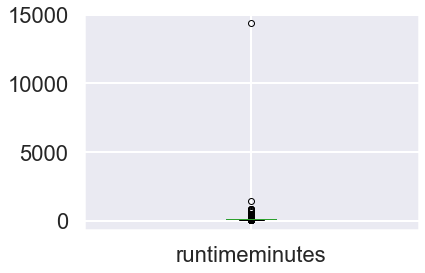

In [96]:
df_clean['runtimeminutes'].plot.box();

To be safe since there are some movies that actually have long runtimes we chose to **drop** any movies that are **longer than 333.0 minutes** for a cleaner data set

In [97]:
df_clean = df_clean[df_clean['runtimeminutes'] <= 333.0]

<br>
Checking;

In [98]:
df_clean['runtimeminutes'].describe()

count    178764.000000
mean        102.077113
std          19.551550
min           8.000000
25%          90.000000
50%          99.000000
75%         112.000000
max         325.000000
Name: runtimeminutes, dtype: float64

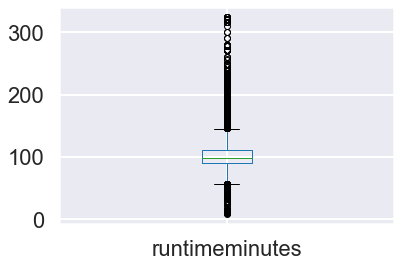

In [99]:
df_clean['runtimeminutes'].plot.box();

We can now actually see something from this box chart, there are still many outliers but after research we are able o conclude 333 minutes will include up to 97% of our data. 

##### Null cleaning
Checking null values throughout the whole data set;

In [100]:
df_clean.isnull().sum()

movieid               0
primarytitle          0
startyear             0
runtimeminutes        0
genres                0
averagerating         0
numvotes              0
region                0
domesticgross         0
foreigngross          0
totalgross            0
genre1                0
genre2            48961
genre3            98005
dtype: int64

Handle any missing data in the genre columns

In [101]:
df_clean.loc[:,['genre1','genre2','genre3']] = df_clean.loc[:,['genre1','genre2','genre3']].fillna(value='N/A')

In [102]:
df_clean[['genre1','genre2','genre3']].isna().sum()

genre1    0
genre2    0
genre3    0
dtype: int64

<br>
Checking;

In [103]:
df_clean.isnull().sum()

movieid           0
primarytitle      0
startyear         0
runtimeminutes    0
genres            0
averagerating     0
numvotes          0
region            0
domesticgross     0
foreigngross      0
totalgross        0
genre1            0
genre2            0
genre3            0
dtype: int64

# Exploratory Data Analysis
What we found:
- Data freshness, years are from 2010-2019. This is slightly stale.
- Explore the top genres and genre combinations
- Explore runtime
- Explore how ratings is related to gross


In [104]:
# Update the revenue filter to only include good values
has_rev_filter = df_clean['totalgross'] != -999999

# Create a filter to just include data from USA
usa_filter = df_clean['region'] == 'US'

### Data Freshness

In [105]:
df_imdb['startyear'].describe()

count    266085.000000
mean       2014.163876
std           2.594150
min        2010.000000
25%        2012.000000
50%        2014.000000
75%        2016.000000
max        2019.000000
Name: startyear, dtype: float64

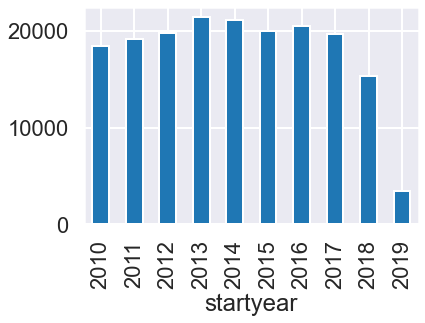

In [106]:
# Check how much data we have for each year
df_clean.groupby('startyear')['movieid'].count().plot.bar();

**Observations**
- This data is from a range of years so we may want to adjust any money values for inflation
- This data does not include the COVID-19 pandemic so any recommendations would need to take that into account

### Genres

In [107]:
# First let's find the top genres
top_genres_combos = list(df_clean[usa_filter].groupby('genres').count().reset_index().nlargest(10, columns='movieid')['genres'])
top_genres_combos

['Drama',
 'Documentary',
 'Comedy',
 'Horror',
 'Comedy,Drama',
 'Horror,Thriller',
 'Comedy,Drama,Romance',
 'Thriller',
 'Drama,Romance',
 'Comedy,Romance']

In [108]:
# Create a filter for only top genres
top_genre_combos_filter = df_clean['genres'].isin(top_genres_combos)

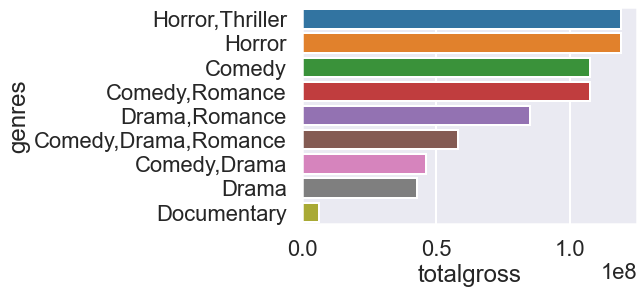

In [109]:
# Compare total gross revenue for common genres
top_genres_filter_final = top_genre_combos_filter & usa_filter & has_rev_filter
top_genre_combos = df_clean[top_genres_filter_final].groupby('genres')['totalgross'].mean().reset_index().sort_values(by='totalgross', ascending=False)
sns.barplot(data=top_genre_combos, x='totalgross', y='genres');

**Observations**
- There are similar combinations (Comedy vs. Comedy,Drama) so we may want to split those out
- One category is much higher than the others, it turned out the there were different currencies here so we needed to split out USD only

Are the differences signficiant however, let's find out?

In [110]:
print(pairwise_tukeyhsd(df_clean[top_genres_filter_final]['totalgross'], df_clean[top_genres_filter_final]['genres']))

                         Multiple Comparison of Means - Tukey HSD, FWER=0.05                          
       group1               group2            meandiff    p-adj       lower          upper      reject
------------------------------------------------------------------------------------------------------
              Comedy         Comedy,Drama  -61601047.7239  0.002 -109056023.6841 -14146071.7636   True
              Comedy Comedy,Drama,Romance  -49386230.2172 0.0164  -93698834.3694  -5073626.0649   True
              Comedy       Comedy,Romance     -12880.0396    0.9  -50484757.7503  50458997.6711  False
              Comedy          Documentary -101542552.9771 0.0012 -177150950.1745 -25934155.7797   True
              Comedy                Drama  -64713049.3767 0.0136 -121876740.2158  -7549358.5375   True
              Comedy        Drama,Romance  -22691780.8312    0.9  -81837162.9483  36453601.2859  False
              Comedy               Horror   11512265.8354    0.9 -1052767

**Observations**
- [TBD]

### Runtime
What we found:
- There were a significant number of outliers
- There were movies with 5k runtime minutes, which is way too long for a movie
- We will want to categorize these to see if there is an optimal length

In [111]:
# Explore the column
df_clean['runtimeminutes'].describe()

count    178764.000000
mean        102.077113
std          19.551550
min           8.000000
25%          90.000000
50%          99.000000
75%         112.000000
max         325.000000
Name: runtimeminutes, dtype: float64

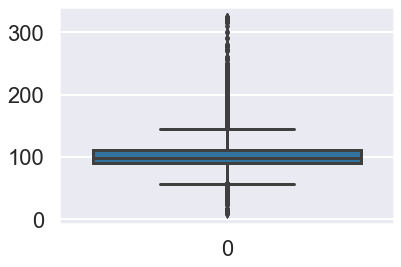

In [112]:
# Let's explore the runtime data
sns.boxplot(data=list(df_clean['runtimeminutes']));

**Observations**
- [TBD]

# Modeling
What we will be doing:
- Categorize movies by genre (split out the genre string)
- Categorize movies based on runtime

### Genre

The current state of our data is:
- movie1: genre1, genre2, genre3

We want to change that to:
- genre1: movie1
- genre2: movie1
- genre3: movie1

This will let us find the average gross revenue by individual genres.

*Note: This approach does double count movies, we're handling this by also comparing the genre combinations*

In [113]:
# Let's start by creating a new dataframe that counts movies for each genre
temp_1 = df_clean[has_rev_filter & usa_filter][['totalgross','genre1']]
temp_2 = df_clean[has_rev_filter & usa_filter][['totalgross','genre2']]
temp_3 = df_clean[has_rev_filter & usa_filter][['totalgross','genre3']]

temp_1.rename(columns={"genre1": "genre"}, inplace=True)
temp_2.rename(columns={"genre2": "genre"}, inplace=True)
temp_3.rename(columns={"genre3": "genre"}, inplace=True)

genre_revenue = temp_1.append(temp_2).append(temp_3).dropna()
genre_revenue = genre_revenue[genre_revenue['genre'] != 'N/A'] # Remove records that don't have a genre
genre_revenue.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4602 entries, 224 to 257150
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   totalgross  4602 non-null   float64
 1   genre       4602 non-null   object 
dtypes: float64(1), object(1)
memory usage: 107.9+ KB


In [114]:
# Let's check value counts
genre_revenue['genre'].value_counts()

Comedy         703
Drama          683
Action         627
Adventure      598
Thriller       299
Crime          224
Sci-Fi         216
Romance        212
Horror         171
Animation      169
Fantasy        156
Mystery        153
Biography      128
Family          97
Music           54
History         38
Documentary     34
Sport           19
War              9
Western          7
Musical          5
Name: genre, dtype: int64

In [115]:
# Let's check stats for the new dataframe
genre_revenue.groupby('genre').describe()

totalgross                                                       \
                 count          mean           std         min          25%   
genre                                                                         
Action           627.0  3.708541e+08  3.441011e+08    369500.0   86350000.0   
Adventure        598.0  4.462942e+08  3.467362e+08   1114800.0  153125000.0   
Animation        169.0  4.287086e+08  3.174449e+08   3055000.0  183400000.0   
Biography        128.0  9.876321e+07  1.338665e+08    608000.0   10225000.0   
Comedy           703.0  1.898266e+08  2.451496e+08    104500.0   35426000.0   
Crime            224.0  1.157454e+08  1.528863e+08     55600.0   27100000.0   
Documentary       34.0  2.013188e+07  2.804722e+07     49400.0     807250.0   
Drama            683.0  1.084767e+08  1.468168e+08     55100.0   17000000.0   
Family            97.0  1.967080e+08  1.760458e+08   2349000.0   72400000.0   
Fantasy          156.0  3.398074e+08  3.416703e+08    346700.0   61425000.0   
History           38.0  1.460110e+08  1.504643e+08    957500.0   23725000.0   
Horror           171.0  1.064454e+08  1.255971e+08    369500.0   24850000.0   
Music             54.0  9.140335e+07  1.477784e+08    569000.0   16600000.0   
Musical            5.0  2.014600e+08  1.966370e+08  28400000.0   59400000.0   
Mystery          153.0  1.129691e+08  1.124735e+08    369500.0   29600000.0   
Romance          212.0  8.965799e+07  1.043170e+08    104500.0   26250000.0   
Sci-Fi           216.0  4.850819e+08  3.712431e+08   1756000.0  215750000.0   
Sport             19.0  6.331543e+07  6.371801e+07   6000600.0   16190950.0   
Thriller         299.0  2.024204e+08  2.519973e+08     55100.0   37900000.0   
War                9.0  4.325833e+07  6.514840e+07    228000.0    1405000.0   
Western            7.0  1.509714e+08  1.637174e+08   9300000.0   11100000.0   

                                                     
                     50%          75%           max  
genre                                                
Action       243800000.0  626100000.0  1.405400e+09  
Adventure    343400000.0  710600000.0  1.405400e+09  
Animation    342700000.0  621500000.0  1.276400e+09  
Biography     46750000.0  136175000.0  9.036000e+08  
Comedy        93200000.0  232350000.0  1.276400e+09  
Crime         68249999.5  155325000.0  7.887000e+08  
Documentary    8600000.0   32593500.0  9.900000e+07  
Drama         55200000.0  140050000.0  9.036000e+08  
Family       165200000.0  299300000.0  1.021100e+09  
Fantasy      197700000.0  644600000.0  1.332600e+09  
History      113750000.0  187800000.0  5.252000e+08  
Horror        77700000.0  122300000.0  7.004000e+08  
Music         45150000.0   91300000.0  9.036000e+08  
Musical       89500000.0  395000000.0  4.350000e+08  
Mystery       82100000.0  155700000.0  5.868000e+08  
Romance       56100000.0  114400000.0  5.710000e+08  
Sci-Fi       375700000.0  714300000.0  1.405400e+09  
Sport         44900000.0   91650000.0  2.140000e+08  
Thriller      97500000.0  260100000.0  1.108600e+09  
War            3800000.0   76600000.0  1.776000e+08  
Western       87200000.0  256350000.0  4.254000e+08

In [116]:
# Create data for plotting
pd.set_option('display.float_format', lambda x: f'{x:.3f}')
genre_revenue_data = genre_revenue.groupby('genre').mean().reset_index().sort_values(by='totalgross', ascending=False)
genre_revenue_data.head()

,genre,totalgross
16,Sci-Fi,485081898.139
1,Adventure,446294245.291
2,Animation,428708609.414
0,Action,370854137.305
9,Fantasy,339807368.571


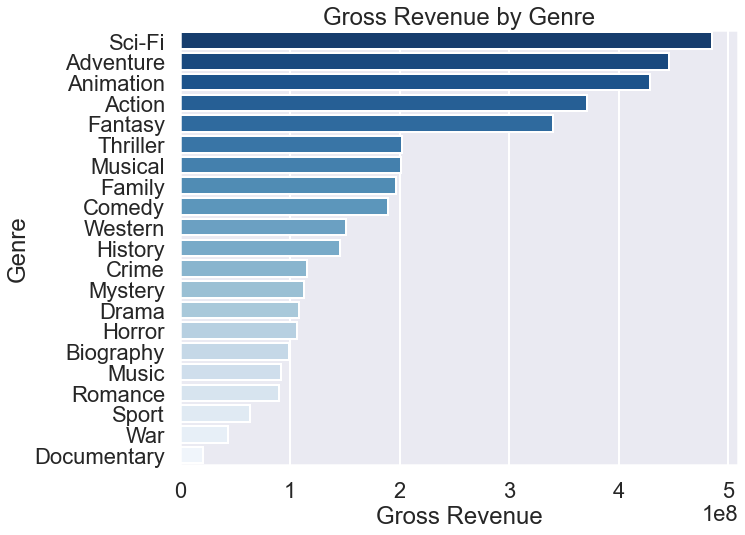

In [117]:
fig, ax = plt.subplots(figsize=(10,8))

n_colors = len(genre_revenue['genre'].value_counts()) # figure out the number of colors needed

sns.barplot(data=genre_revenue_data, 
            x='totalgross', 
            y='genre', 
            ax=ax, 
            palette=reversed(sns.color_palette("Blues", n_colors))
            )
ax.set_xlabel('Gross Revenue')
ax.set_ylabel('Genre')
ax.set_title('Gross Revenue by Genre')
fig.savefig('images/genre_revenue.png', dpi='figure', bbox_inches='tight');

In [118]:
# Check the significance
print(pairwise_tukeyhsd(genre_revenue['totalgross'], genre_revenue['genre']))

                 Multiple Comparison of Means - Tukey HSD, FWER=0.05                 
   group1      group2       meandiff    p-adj       lower           upper      reject
-------------------------------------------------------------------------------------
     Action   Adventure   75440107.9863  0.001   22666086.9323  128214129.0404   True
     Action   Animation   57854472.1096  0.537  -22168728.0865  137877672.3057  False
     Action   Biography -272090922.4609  0.001 -361642084.2704 -182539760.6514   True
     Action      Comedy -181027541.1681  0.001 -231744229.9801  -130310852.356   True
     Action       Crime -255108716.3314  0.001 -326978031.1621 -183239401.5007   True
     Action Documentary -350722257.9223  0.001 -513301092.0525 -188143423.7921   True
     Action       Drama -262377420.1816  0.001 -313442972.0392 -211311868.3241   True
     Action      Family -174146123.9026  0.001 -274882459.6772  -73409788.1279   True
     Action     Fantasy  -31046768.7341    0.9 -113654

**Observations**
With a 95% confidence level we can conclude:
- Sci-Fi is not greater than Adventure
- Adventure is not greater than Animation
- Sci-Fi & Adventure > (Action & Fantasy)
- Top 5 are > Thriller

### Runtime

We need to start feature engineering for runtime. Instead of trying to optimize runtime for gross revenue we will instead categorize runtime and compare revenue among the newly created categories

In [119]:
# Create a function to categorize runtimes
def film_categorization(runtime):
    """
    Input: the movie runtime (float)
    Output: the movie runtime category (string)
    """
    movie_category = ''
    if runtime < 40: # The movie industry considers this a short film
        movie_category =  'Short Film'
    elif runtime < 96: # This is outside the common hollywood length
        movie_category =  'Normal Film (short)'
    elif (runtime >= 96) and (runtime <= 120): # 50% of hollywood movies are in this range
        movie_category =  'Normal Film (optimal)'
    elif (runtime > 120): # These are longer than the common range
        movie_category =  'Normal Film (long)'
    else: # if no runtime exists
        movie_category =  'No Runtime'
    return movie_category

In [120]:
# Add a new column categorizing the runtime
df_clean['runtimecategory'] = df_clean['runtimeminutes'].apply(film_categorization)
df_clean['runtimecategory'].value_counts()

Normal Film (optimal)    77773
Normal Film (short)      74940
Normal Film (long)       26001
Short Film                  50
Name: runtimecategory, dtype: int64

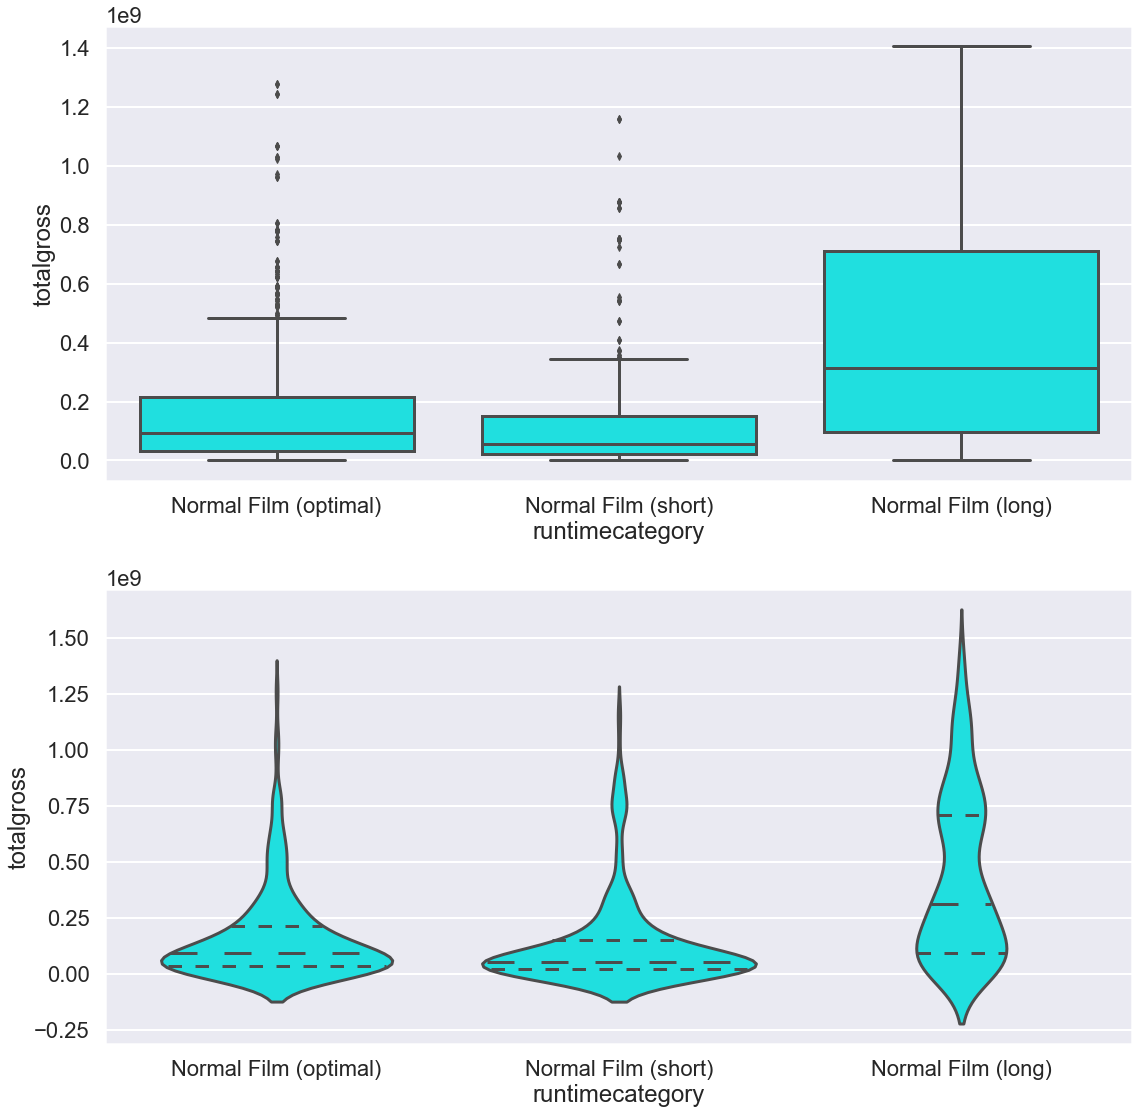

In [121]:
# Visualize the distributions
fig, (ax0,ax1) = plt.subplots(nrows=2, figsize=(16, 16))

data = df_clean[has_rev_filter & usa_filter]

sns.boxplot(
    x="runtimecategory",
    y="totalgross",
    data=data,
    ax=ax0,
    color='aqua', 
    linewidth=3
)



sns.violinplot(
    x="runtimecategory",
    y="totalgross",
    data=data,
    ax=ax1,
    color='aqua',
    inner="quartile",  # Seeing the mean and quartiles
    bw=.3              # How much smoothing do we use
)

plt.tight_layout();

In [122]:
# Check for significant differences between the four categories
print(pairwise_tukeyhsd(data['totalgross'], data['runtimecategory']))

                           Multiple Comparison of Means - Tukey HSD, FWER=0.05                           
        group1                group2            meandiff    p-adj       lower           upper      reject
---------------------------------------------------------------------------------------------------------
   Normal Film (long) Normal Film (optimal) -263863989.0305  0.001  -298872875.071 -228855102.9899   True
   Normal Film (long)   Normal Film (short) -292960291.0818  0.001 -334961328.3142 -250959253.8493   True
Normal Film (optimal)   Normal Film (short)  -29096302.0513 0.1512  -65807592.1989    7614988.0963  False
---------------------------------------------------------------------------------------------------------


**Observations**
- [TBD]

In [123]:
# Create data for barplot
data = df_clean[has_rev_filter & usa_filter].groupby('runtimecategory').mean().reset_index().sort_values('totalgross', ascending=False)
data[['runtimecategory', 'totalgross']]

,runtimecategory,totalgross
0,Normal Film (long),429857141.054
1,Normal Film (optimal),165993152.023
2,Normal Film (short),136896849.972


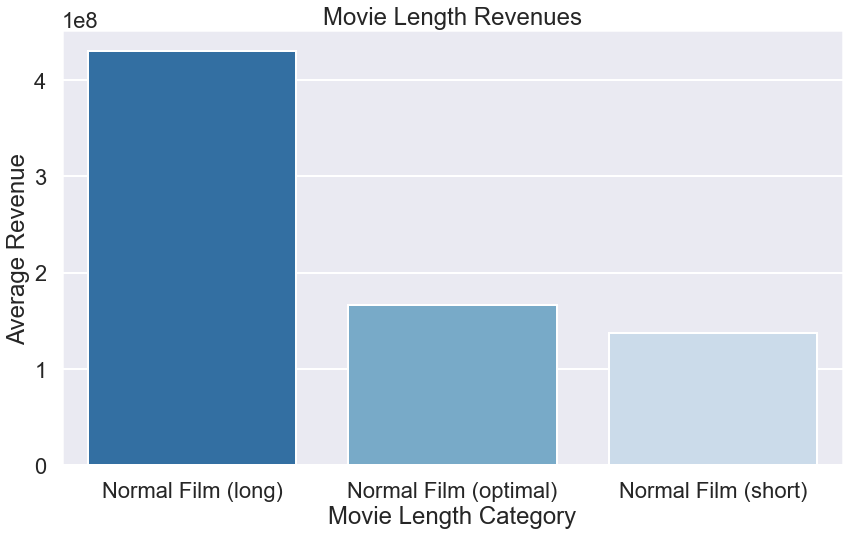

In [124]:
fig, ax = plt.subplots(figsize=(14,8))

n_colors = len(data['runtimecategory'].value_counts()) # figure out the number of colors needed

sns.barplot(data=data, 
            x='runtimecategory', 
            y='totalgross', 
            ax=ax, 
            palette=reversed(sns.color_palette("Blues", n_colors))
            )
ax.set_xlabel('Movie Length Category')
ax.set_ylabel('Average Revenue')
ax.set_title('Movie Length Revenues')
fig.savefig('images/runtime_revenue.png', dpi='figure', bbox_inches='tight');

In [168]:
# Create data for plotting comparing domestic vs. foreign revenue
data = df_clean[has_rev_filter & usa_filter][['runtimecategory', 'domesticgross', 'foreigngross']]

data_for_plot = pd.melt(data, id_vars=['runtimecategory'], value_vars=['domesticgross', 'foreigngross'], var_name='grossloc', value_name='gross')

data_for_plot = data_for_plot.groupby(['runtimecategory', 'grossloc']).mean().reset_index().sort_values(by='gross', ascending=False)

data_for_plot


,runtimecategory,grossloc,gross
1,Normal Film (long),foreigngross,271669837.721
0,Normal Film (long),domesticgross,158187303.333
3,Normal Film (optimal),foreigngross,97841121.554
5,Normal Film (short),foreigngross,83854190.759
2,Normal Film (optimal),domesticgross,68152030.469
4,Normal Film (short),domesticgross,53042659.213


Let's break that down by foreign and domestic markets to see the influence

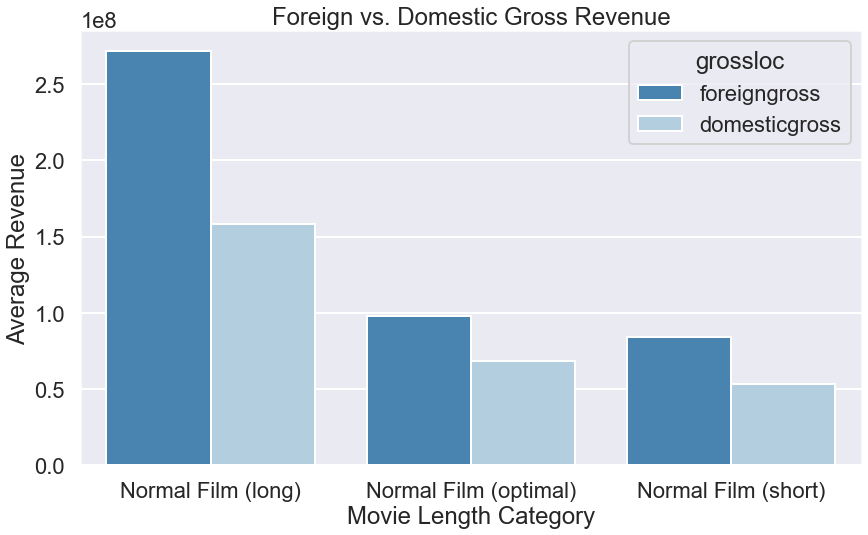

In [178]:
fig, ax = plt.subplots(figsize=(14,8))

sns.barplot(data=data_for_plot, 
            x='runtimecategory', 
            y='gross', 
            ax=ax, 
            hue='grossloc',
            palette=reversed(sns.color_palette("Blues", 2))
            )
ax.set_xlabel('Movie Length Category')
ax.set_ylabel('Average Revenue')
ax.set_title('Foreign vs. Domestic Gross Revenue')
fig.savefig('images/foreign_vs_domestic_gross.png', dpi='figure', bbox_inches='tight');

### Revenue vs. Rating
Todo:
- Plot revenue vs. rating and investigate trends
- Run a linear regresion model to explore the relationship

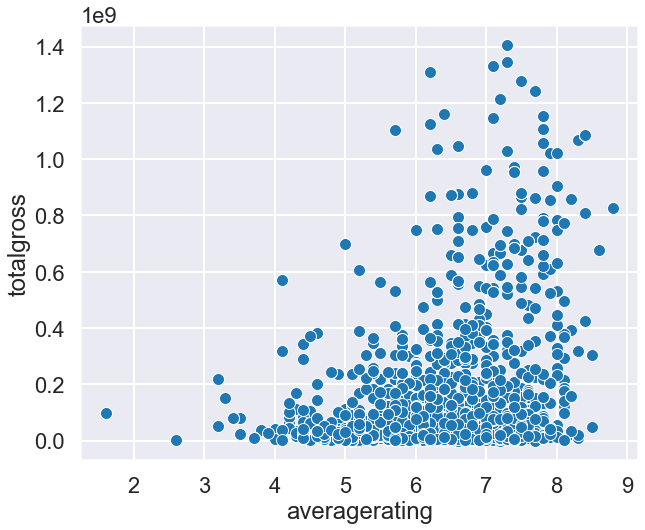

In [125]:
# Plot revenue vs. rating
fig, ax = plt.subplots(figsize=(10, 8))
sns.scatterplot(data=df_clean[has_rev_filter & usa_filter], x='averagerating', y='totalgross', ax=ax);

**Observations**
- It looks like there is a slight upwards trend
- There seems to be a lot of spread

In [126]:
# We also need to find the correlation coefficient
num_ratings_filter = df_clean['numvotes'] >= 30 # Only include movies with over 30 votes
filter_for_ratings = has_rev_filter & usa_filter & num_ratings_filter
x = df_clean[filter_for_ratings]['totalgross']
y = df_clean[filter_for_ratings]['averagerating']
coer_data = np.corrcoef(x, y)
print(f'The correlation coefficient is: {round(coer_data[0,1],4)}')

The correlation coefficient is: 0.3553


In [127]:
# Let's run a simple linear regression model
endog = df_clean[filter_for_ratings]['totalgross'] # Revenue is independant
exog = sm.add_constant(df_clean[filter_for_ratings]['averagerating']) # Rating is dependant
lin_reg_model = sm.OLS(endog, exog)
lin_reg_model.fit()
results = lin_reg_model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             totalgross   R-squared:                       0.126
Model:                            OLS   Adj. R-squared:                  0.126
Method:                 Least Squares   F-statistic:                     252.2
Date:                Fri, 12 May 2023   Prob (F-statistic):           3.84e-53
Time:                        10:20:08   Log-Likelihood:                -36369.
No. Observations:                1747   AIC:                         7.274e+04
Df Residuals:                    1745   BIC:                         7.275e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -4.125e+08   4.08e+07    -10.115      0.000   -4.93e+08   -3.33e+08
averagerating  9.961e+07   6.27e+06     15.880      0.000    8.73e+07    1.12e+08
==============================================================================
Omnibus:                      485.230   Durbin-Watson:                   0.863
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1119.187
Skew:                           1.543   Prob(JB):                    9.37e-244
Kurtosis:                       5.418   Cond. No.                         42.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Observations**
- There is a loose relationship between ratings and revenue (r-squared = 0.126)
- There is a confirmed positive relationship with a 95% confidence level 
- The best fit line has a slope between [8.73e+07, 1.12e+08]

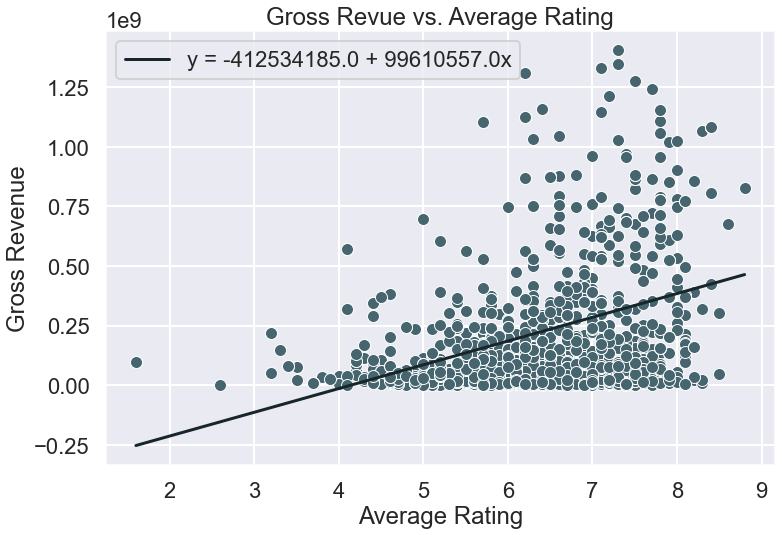

In [137]:
# Plot revenue vs. rating
fig, ax = plt.subplots(figsize=(12, 8))
data = df_clean[filter_for_ratings]

# Create the line of best fit
data_length = len(data)
x = data['averagerating'] # Create the x for the line (millions)
y = results.params.const + results.params.averagerating * x # Create the c for the line
label = f'y = {round(results.params.const)} + {round(results.params.averagerating)}x'

# Plot both the data and the new line
sns.lineplot(x=x, y=y, ax=ax, color='#17262a', label=label)
sns.scatterplot(data=data, x='averagerating', y='totalgross', ax=ax, color='#46656f')
ax.set_xlabel('Average Rating')
ax.set_ylabel('Gross Revenue')
ax.set_title('Gross Revue vs. Average Rating') # comment out for presentation
fig.savefig('images/rev_vs_rating.png', dpi='figure', bbox_inches='tight');